In [1]:
!pip install openai-clip
!pip install ftfy regex tqdm
!pip install torch torchvision

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 23.5 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 4.3 MB/s eta 0:00:00
  Created wheel for openai-clip: filename=openai_clip-1.0.1-py3-none-any.whl size=1368605 sha256=1cce17d4890cff61813be33ad3ede4bf21df6cf119d346f2acf3171aa429bf79
  Stored in directory: /root/.cache/pip/wheels/0d/17/90/042948fd2e2a87f1dcf6db6d438cad015c49db0c53d1d9c7dc
Successfully built openai-clip
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 1.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 138.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 105.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 63.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━

In [2]:
import os
import json
from tqdm import tqdm
import torch
import clip
from PIL import Image
import numpy as np

In [3]:
image_folder = "/content/sample_data/animals"
output_embeddings = "embeddings.npy"
output_filenames = "filenames.json"
device = "cuda" if torch.cuda.is_available() else "cpu"

In [4]:
model, preprocess = clip.load("ViT-B/32", device=device)
model.eval()

100%|███████████████████████████████████████| 338M/338M [00:09<00:00, 36.7MiB/s]


CLIP(
  (visual): VisionTransformer(
    (conv1): Conv2d(3, 768, kernel_size=(32, 32), stride=(32, 32), bias=False)
    (ln_pre): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
    (transformer): Transformer(
      (resblocks): Sequential(
        (0): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          )
          (ln_1): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (mlp): Sequential(
            (c_fc): Linear(in_features=768, out_features=3072, bias=True)
            (gelu): QuickGELU()
            (c_proj): Linear(in_features=3072, out_features=768, bias=True)
          )
          (ln_2): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        )
        (1): ResidualAttentionBlock(
          (attn): MultiheadAttention(
            (out_proj): NonDynamicallyQuantizableLinear(in_features=768, out_features=768, bias=True)
          

In [5]:
image_files = [os.path.join(image_folder, fname)
               for fname in os.listdir(image_folder)
               if fname.lower().endswith(('.png', '.jpg', '.jpeg', '.bmp', '.gif', 'webp', 'avif'))]

embeddings = []
filenames = []

In [6]:
with torch.no_grad():
    for img_path in tqdm(image_files, desc="Processing images"):
        try:
            image = Image.open(img_path).convert("RGB")
            image_input = preprocess(image).unsqueeze(0).to(device)

            image_features = model.encode_image(image_input)
            image_features /= image_features.norm(dim=-1, keepdim=True)
            embeddings.append(image_features.squeeze(0).cpu().numpy())
            filenames.append(os.path.basename(img_path))
        except Exception as e:
            print(f"⚠️ Ошибка на {img_path}: {e}")

embeddings = np.stack(embeddings)

Processing images:   8%|▊         | 26/320 [00:04<00:45,  6.53it/s]/usr/local/lib/python3.11/dist-packages/PIL/Image.py:3570: UserWarning: image file could not be identified because AVIF support not installed
  warnings.warn(message)
Processing images:   9%|▉         | 28/320 [00:04<00:40,  7.21it/s]

⚠️ Ошибка на /content/sample_data/animals/mouse2.jpg: cannot identify image file '/content/sample_data/animals/mouse2.jpg'


Processing images: 100%|██████████| 320/320 [00:53<00:00,  6.03it/s]


In [7]:
np.save(output_embeddings, embeddings)
with open(output_filenames, "w", encoding="utf-8") as f:
    json.dump(filenames, f, ensure_ascii=False, indent=2)

print(f"✅ Готово! Сохранено {len(embeddings)} эмбеддингов в {output_embeddings}")
print(f"✅ Имена файлов сохранены в {output_filenames}")

✅ Готово! Сохранено 319 эмбеддингов в embeddings.npy
✅ Имена файлов сохранены в filenames.json


In [8]:
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [9]:
embeddings = np.load("embeddings.npy")
X = torch.tensor(embeddings, dtype=torch.float32)

In [10]:
batch_size = 32
dataset = TensorDataset(X)
loader = DataLoader(dataset, batch_size=batch_size, shuffle=True)

In [11]:
class SparseAutoencoder(nn.Module):
    def __init__(self, input_dim=512, hidden_dim=128):
        super().__init__()
        self.encoder = nn.Linear(input_dim, hidden_dim)
        self.decoder = nn.Linear(hidden_dim, input_dim)

    def forward(self, x):
        h = self.encoder(x)
        x_hat = self.decoder(h)
        return x_hat, h

In [12]:
hidden_dim = 128
lr = 1e-3
num_epochs = 50
lambda_l1 = 1e-3

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
model = SparseAutoencoder(input_dim=512, hidden_dim=hidden_dim).to(device)
optimizer = optim.Adam(model.parameters(), lr=lr)
mse_loss = nn.MSELoss()

In [14]:
model.train()
for epoch in range(num_epochs):
    total_loss = 0
    for (batch,) in loader:
        batch = batch.to(device)

        optimizer.zero_grad()
        x_hat, h = model(batch)

        mse = mse_loss(x_hat, batch)
        l1 = torch.mean(torch.abs(h))
        loss = mse + lambda_l1 * l1

        loss.backward()
        optimizer.step()
        total_loss += loss.item() * batch.size(0)

    avg_loss = total_loss / len(loader.dataset)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_loss:.6f}")

torch.save(model.state_dict(), "sparse_autoencoder.pth")
print("✅ Обучение завершено, модель сохранена.")

Epoch [1/50], Loss: 0.003078
Epoch [2/50], Loss: 0.001195
Epoch [3/50], Loss: 0.000833
Epoch [4/50], Loss: 0.000687
Epoch [5/50], Loss: 0.000628
Epoch [6/50], Loss: 0.000580
Epoch [7/50], Loss: 0.000538
Epoch [8/50], Loss: 0.000501
Epoch [9/50], Loss: 0.000468
Epoch [10/50], Loss: 0.000439
Epoch [11/50], Loss: 0.000414
Epoch [12/50], Loss: 0.000392
Epoch [13/50], Loss: 0.000373
Epoch [14/50], Loss: 0.000356
Epoch [15/50], Loss: 0.000341
Epoch [16/50], Loss: 0.000328
Epoch [17/50], Loss: 0.000315
Epoch [18/50], Loss: 0.000304
Epoch [19/50], Loss: 0.000293
Epoch [20/50], Loss: 0.000284
Epoch [21/50], Loss: 0.000275
Epoch [22/50], Loss: 0.000267
Epoch [23/50], Loss: 0.000260
Epoch [24/50], Loss: 0.000253
Epoch [25/50], Loss: 0.000247
Epoch [26/50], Loss: 0.000241
Epoch [27/50], Loss: 0.000235
Epoch [28/50], Loss: 0.000230
Epoch [29/50], Loss: 0.000225
Epoch [30/50], Loss: 0.000220
Epoch [31/50], Loss: 0.000216
Epoch [32/50], Loss: 0.000212
Epoch [33/50], Loss: 0.000208
Epoch [34/50], Loss

In [15]:
X = torch.tensor(np.load("embeddings.npy"), dtype=torch.float32)
with open("filenames.json", "r", encoding="utf-8") as f:
    filenames = json.load(f)

In [16]:
hidden_dim = 128
model = SparseAutoencoder(input_dim=512, hidden_dim=hidden_dim)
model.load_state_dict(torch.load("sparse_autoencoder.pth", map_location="cpu"))
model.eval()

SparseAutoencoder(
  (encoder): Linear(in_features=512, out_features=128, bias=True)
  (decoder): Linear(in_features=128, out_features=512, bias=True)
)

In [17]:
with torch.no_grad():
    _, H = model(X)  # (N, hidden_dim)

H = H.numpy()

In [19]:
import matplotlib.pyplot as plt

def show_images(image_paths, n=5):
    plt.figure(figsize=(15, 3))
    for i, path in enumerate(image_paths[:n]):
        plt.subplot(1, n, i+1)
        img = Image.open(os.path.join(image_folder, path)).convert("RGB")
        plt.imshow(img)
        plt.title(path, fontsize=8)
        plt.axis("off")
    plt.show()


🧠 Нейрон 0:
Топ-5 картинок с наибольшей активацией:


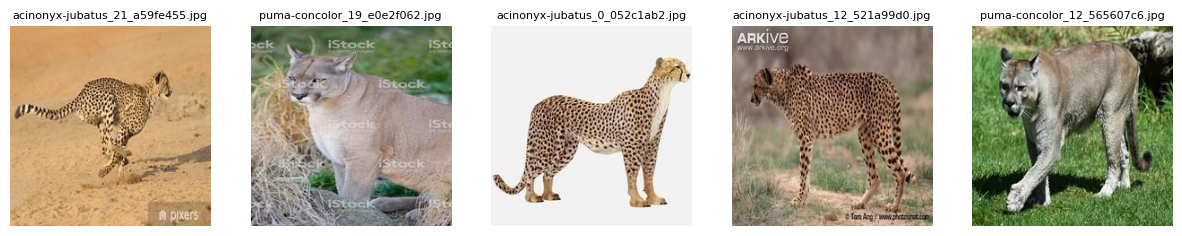


🧠 Нейрон 1:
Топ-5 картинок с наибольшей активацией:


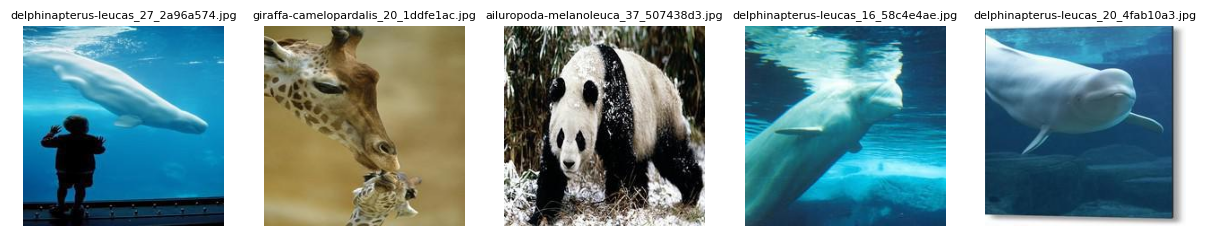


🧠 Нейрон 2:
Топ-5 картинок с наибольшей активацией:


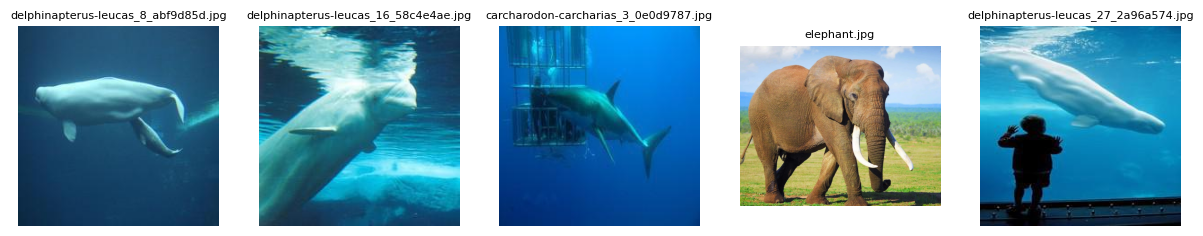


🧠 Нейрон 3:
Топ-5 картинок с наибольшей активацией:


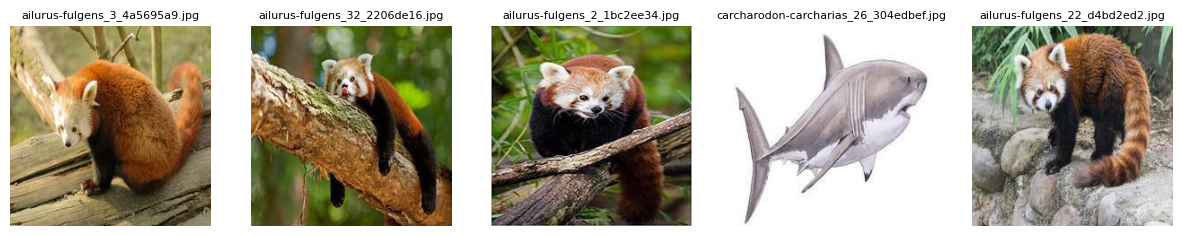


🧠 Нейрон 4:
Топ-5 картинок с наибольшей активацией:


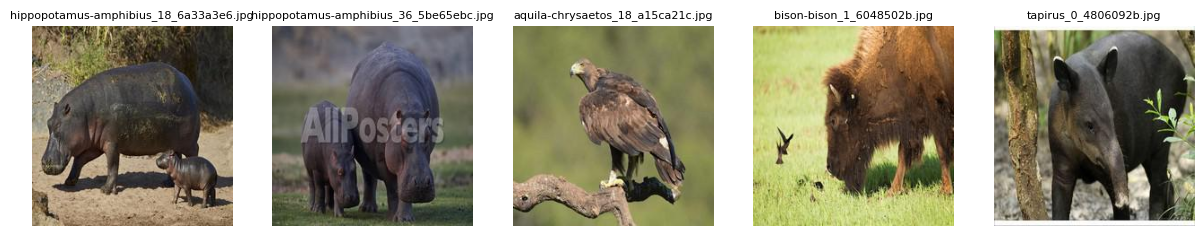


🧠 Нейрон 5:
Топ-5 картинок с наибольшей активацией:


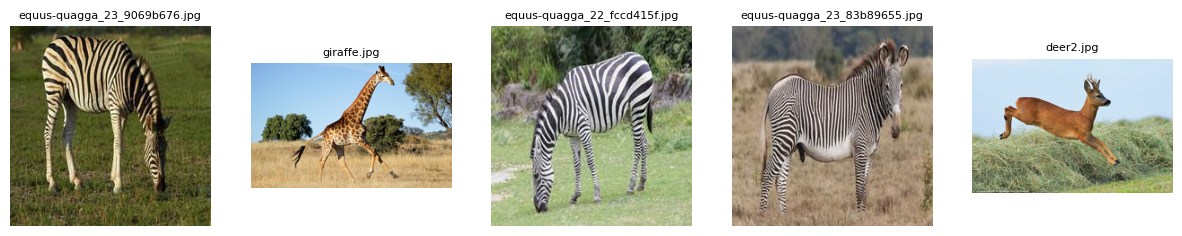

In [21]:
top_k = 5

for neuron in range(6):
    activations = H[:, neuron]
    top_indices = np.argsort(-activations)[:top_k]
    top_files = [filenames[i] for i in top_indices]

    print(f"\n🧠 Нейрон {neuron}:")
    print(f"Топ-{top_k} картинок с наибольшей активацией:")
    show_images(top_files)

In [22]:
import plotly.express as px
import pandas as pd

X = torch.tensor(np.load("embeddings.npy"), dtype=torch.float32)
with open("filenames.json", "r", encoding="utf-8") as f:
    filenames = json.load(f)

In [23]:
hidden_dim = 128
model = SparseAutoencoder(input_dim=512, hidden_dim=hidden_dim)
model.load_state_dict(torch.load("sparse_autoencoder.pth", map_location="cpu"))
model.eval()

SparseAutoencoder(
  (encoder): Linear(in_features=512, out_features=128, bias=True)
  (decoder): Linear(in_features=128, out_features=512, bias=True)
)

In [25]:
with torch.no_grad():
    _, H = model(X)

H = H.numpy()

In [26]:
def visualize_neuron(neuron_idx):
    activations = H[:, neuron_idx]

    df = pd.DataFrame({
        "activation": activations,
        "filename": filenames
    }).sort_values(by="activation", ascending=False).reset_index()

    df["path"] = df["filename"].apply(lambda x: os.path.join(image_folder, x))
    df["img_tag"] = df["path"].apply(lambda p: f'<img src="{p}" width="100">' if os.path.exists(p) else "нет картинки")

    fig = px.scatter(
        df,
        x=df.index,
        y="activation",
        hover_name="filename",
        hover_data={"activation": True, "filename": False, "img_tag": True},
        title=f"🧠 Нейрон {neuron_idx}: активации по изображениям",
        labels={"x": "Ранг", "activation": "Активация"}
    )

    fig.update_traces(marker=dict(size=8, color="blue"))

    fig.update_traces(
        hovertemplate=
        "<b>%{hovertext}</b><br><br>" +
        "Активация: %{y:.4f}<br>" +
        "%{customdata[0]}<br>" +
        "<extra></extra>"
    )
    fig.show()


In [30]:
visualize_neuron(12)